In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import *
from sklearn.kernel_ridge import KernelRidge as KR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import datetime as dt
import math
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.inspection import permutation_importance

In [2]:
def print_plots_results(model_name, test, pred):
    fig, (basic, residuals, hist) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    
    basic.scatter(test, pred)
    basic.set_xlabel('Y test')
    basic.set_ylabel('Predicted')
    basic.set_title('Test vs. Predicted')
    mb_params = np.vstack([test,np.ones(len(test))]).T
    m,b = np.linalg.lstsq(mb_params,pred, rcond=None)[0]
    basic.plot(test, m*test+b,'r')

    
    # Scatter plot of y_test vs residuals
    residuals.scatter(test, test - pred)
    residuals.set_xlabel('Observed')
    residuals.set_ylabel('Residuals')
    residuals.set_title('Observed vs Residuals')
    residuals.axhline(color='r')
    
    # Histogram of residuals
    sns.histplot(test - pred, kde=True, ax=hist)
    hist.set_xlabel('Residuals')
    hist.set_ylabel('Frequency')
    hist.set_title('Histogram of Residuals')

    print(model_name)
    
    plt.show()
    print_scores(test, pred)

def print_scores(test, pred):
    print('MAE:  ', "%.4f" % mean_absolute_error(test, pred))
    print('MSE:  ', "%.4f" % mean_squared_error(test, pred))
    print('RMSE:  ', "%.4f" % np.sqrt(mean_squared_error(test, pred)))
    print('R2:  ', "%.4f" % r2_score(test, pred))


In [62]:
primero_df = pd.read_csv('https://github.com/idanwork22/intro_to_data_science_project/blob/master/final_csv/final_csv.csv?raw=true')

In [4]:
primero_df.head()

,website,snapshot_number,snapshot_date,start_date_str,end_date_str,ttt,los,name,rating,price,reviews_amount,index_in_page,weekend,rating_category,avg_price_per_day
0,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Pod 51,7.8,632.0,10744,1,1,7-8,632.0
1,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Hyatt Place New York/Midtown-South,8.2,693.0,3209,2,1,8-9,693.0
2,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Hyatt Place New York City/Times Square,7.6,693.0,21747,3,1,7-8,693.0
3,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Hyatt Place NYC Chelsea,7.9,693.0,15066,4,1,7-8,693.0
4,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Tuscany by LuxUrban,7.4,569.0,2297,5,1,7-8,569.0


In [63]:
primero_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180304 entries, 0 to 180303
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   website            180304 non-null  object 
 1   snapshot_number    180304 non-null  int64  
 2   snapshot_date      180304 non-null  object 
 3   start_date_str     180304 non-null  object 
 4   end_date_str       180304 non-null  object 
 5   ttt                180304 non-null  int64  
 6   los                180304 non-null  int64  
 7   name               180304 non-null  object 
 8   rating             180304 non-null  float64
 9   price              180304 non-null  float64
 10  reviews_amount     180304 non-null  int64  
 11  index_in_page      180304 non-null  int64  
 12  weekend            180304 non-null  int64  
 13  rating_category    138910 non-null  object 
 14  avg_price_per_day  180304 non-null  float64
dtypes: float64(3), int64(6), object(6)
memory usage: 20

In [6]:
booking_df = primero_df[primero_df["website"]=="Booking"]

In [7]:
expedia_df = primero_df[primero_df["website"]=="Expedia"]

### Preprocess data 

In [8]:
drop_columns = ['snapshot_number',
                'snapshot_date',
                'rating_category',
                'end_date_str',
                'website',
                'index_in_page',
                'weekend']

In [9]:
booking = booking_df.rename(columns={'rating': 'b_rating',
                                    'price': 'b_price',
                                    'reviews_amount':'b_reviews',
                                    'avg_price_per_day':'b_avg_price'}).drop(drop_columns, axis=1)
expedia = expedia_df.rename(columns={'rating': 'e_rating',
                                    'price': 'e_price',
                                    'reviews_amount':'e_reviews',
                                    'avg_price_per_day':'e_avg_price'}).drop(drop_columns, axis=1)

In [60]:
merged = pd.merge(booking, expedia, on=['name',
                                        'start_date_str',
                                        'los',
                                        'ttt',
                                        'weekend'],
                  how='inner')

In [61]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14215 entries, 0 to 14214
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   start_date_str  14215 non-null  object 
 1   ttt             14215 non-null  int64  
 2   los             14215 non-null  int64  
 3   name            14215 non-null  object 
 4   b_rating        14215 non-null  float64
 5   b_price         14215 non-null  float64
 6   b_reviews       14215 non-null  int64  
 7   weekend         14215 non-null  int64  
 8   b_avg_price     14215 non-null  float64
 9   e_rating        14215 non-null  float64
 10  e_price         14215 non-null  float64
 11  e_reviews       14215 non-null  int64  
 12  e_avg_price     14215 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 1.4+ MB


In [12]:
hotels = merged
hotels['price_diff'] = merged['b_price'] - merged['e_price']
hotels['avg_price_diff'] = merged['b_avg_price'] - merged['e_avg_price']
hotels['rating_diff'] = merged['b_rating'] - merged['e_rating']
hotels['reviews_diff'] = merged['b_reviews'] - merged['e_reviews']
hotels['start_date_str'] = pd.to_datetime(hotels['start_date_str'])
hotels['start_date_str'] = hotels['start_date_str'].map(dt.datetime.toordinal)

added_columns = ['avg_price_diff','rating_diff','reviews_diff']

In [13]:
le = LabelEncoder()
hotels['name'] = le.fit_transform(hotels['name'])

In [14]:
unique_encoded = hotels['name'].unique()
unique_decoded = le.inverse_transform(unique_encoded)
hotel_names_index = pd.DataFrame({'hotel_name':unique_decoded, 'hotel_code': unique_encoded})

## Split Data

In [15]:
X = hotels.drop(["price_diff"], axis=1)
y = hotels["price_diff"]

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3 )

## Extra Features

In [16]:
train_ef = pd.DataFrame()
test_ef = pd.DataFrame()

In [17]:
train_ef['end_of_month'] = (pd.to_datetime(X_train['start_date_str']).dt.is_month_end).astype(int)
test_ef['end_of_month'] = (pd.to_datetime(X_test['start_date_str']).dt.is_month_end).astype(int)

train_ef['b_reviews_rating'] = X_train['b_reviews'] * X_train['b_rating']
test_ef['b_reviews_rating'] = X_test['b_reviews'] * X_test['b_rating']

train_ef['e_reviews_rating'] = X_train['e_reviews'] * X_train['e_rating']
test_ef['e_reviews_rating'] = X_test['e_reviews'] * X_test['e_rating']

X_ef_train = pd.concat([X_train, train_ef], axis=1)
X_ef_test = pd.concat([X_test, test_ef], axis=1)

In [18]:
all_features = X_ef_test.columns

### For Gaussian Processes

In [19]:
y_mean = y.mean()
y_new = y - y_mean

X_train_gp, X_test_gp, y_train_gp, y_test_gp = train_test_split(X,y_new, test_size=0.3 )

In [20]:
train_ef_gp = pd.DataFrame()
test_ef_gp = pd.DataFrame()

In [21]:

train_ef_gp['end_of_month'] = (pd.to_datetime(X_train_gp['start_date_str']).dt.is_month_end).astype(int)
test_ef_gp['end_of_month'] = (pd.to_datetime(X_test_gp['start_date_str']).dt.is_month_end).astype(int)

train_ef_gp['b_reviews_rating'] = X_train_gp['b_reviews'] * X_train_gp['b_rating']
test_ef_gp['b_reviews_rating'] = X_test_gp['b_reviews'] * X_test_gp['b_rating']

train_ef_gp['e_reviews_rating'] = X_train_gp['e_reviews'] * X_train_gp['e_rating']
test_ef_gp['e_reviews_rating'] = X_test_gp['e_reviews'] * X_test_gp['e_rating']

X_ef_train_gp = pd.concat([X_train_gp, train_ef_gp], axis=1)
X_ef_test_gp = pd.concat([X_test_gp, test_ef_gp], axis=1)

### Scaling data for use in different scenarios

In [22]:
scaler = MinMaxScaler()

X_train_scaled_mm = scaler.fit_transform(X_train)
X_test_scaled_mm = scaler.transform(X_test)

X_ef_train_scaled_mm = scaler.fit_transform(X_ef_train)
X_ef_test_scaled_mm = scaler.fit_transform(X_ef_test)

X_train_scaled_mm_gp = scaler.fit_transform(X_train_gp)
X_test_scaled_mm_gp = scaler.fit_transform(X_test_gp)

X_ef_train_scaled_mm_gp = scaler.fit_transform(X_ef_train_gp)
X_ef_test_scaled_mm_gp = scaler.fit_transform(X_ef_test_gp)

In [23]:
scaler = RobustScaler()
X_train_scaled_rob = scaler.fit_transform(X_train)
X_test_scaled_rob = scaler.transform(X_test)

X_ef_train_scaled_rob = scaler.fit_transform(X_ef_train)
X_ef_test_scaled_rob = scaler.fit_transform(X_ef_test)

## Linear Regression

Basic Linear Model


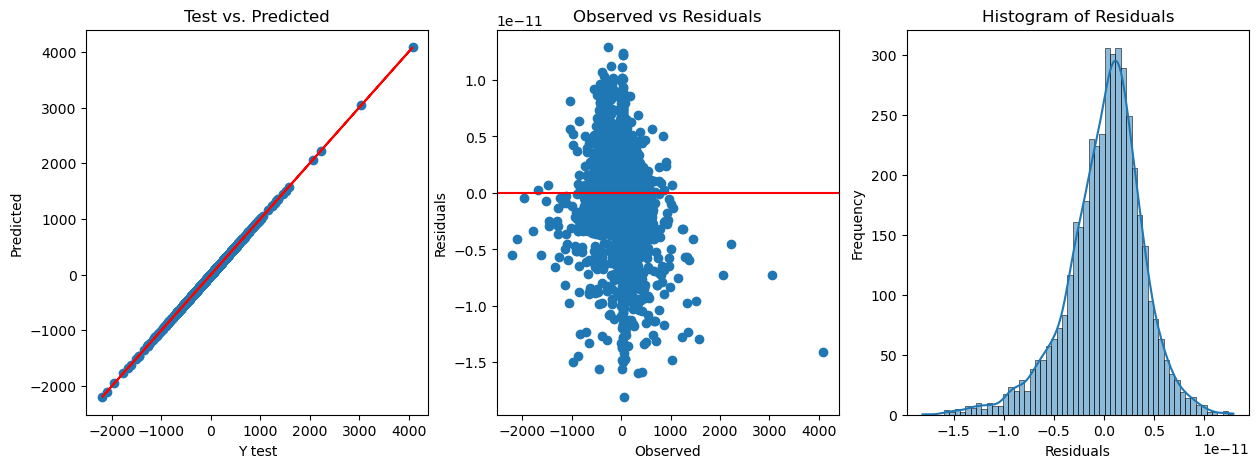

MAE:   0.0000
MSE:   0.0000
RMSE:   0.0000
R2:   1.0000


In [24]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

lr1_y_pred = lr1.predict(X_test)

print_plots_results("Basic Linear Model", y_test, lr1_y_pred)

Fit inter is false Linear Model


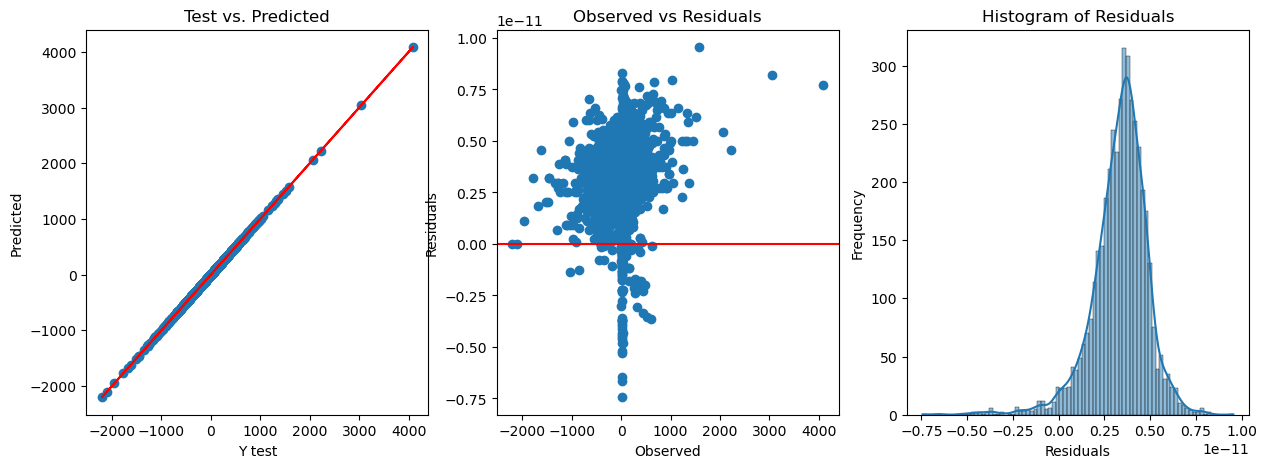

MAE:   0.0000
MSE:   0.0000
RMSE:   0.0000
R2:   1.0000


In [25]:
lr2 = LinearRegression(fit_intercept=False)
lr2.fit(X_train, y_train)

lr2_y_pred = lr2.predict(X_test)

print_plots_results("Fit inter is false Linear Model", y_test, lr2_y_pred)

Fit inter is false Linear Model


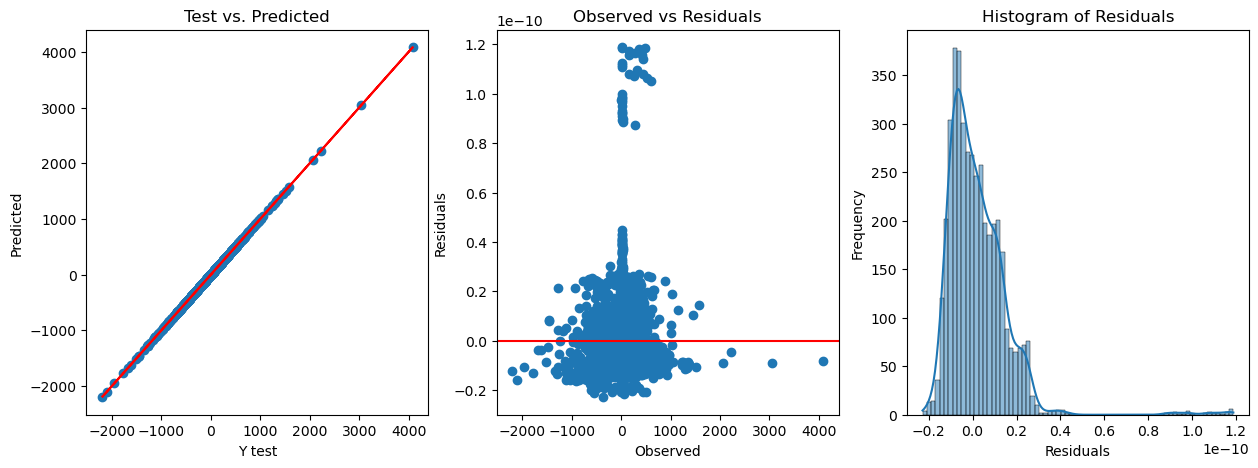

MAE:   0.0000
MSE:   0.0000
RMSE:   0.0000
R2:   1.0000


In [26]:
lr3 = LinearRegression(fit_intercept=False)
lr3.fit(X_ef_train, y_train)

lr3_y_pred = lr3.predict(X_ef_test)

print_plots_results("Fit inter is false Linear Model", y_test, lr3_y_pred)

## Conclusion
#### All linear models got an R2 score of 1, not only that, we can see that the residuals graph is covering a very small scale (1e-11), which indicates that the errors are very small. Still i'd like to mention that if this graph was on higher scale it would not indicate a good disposition of the residuals as they are clustred quite far from the 0 line.
#### Although the R2 score and the errors look good, this is pointing to overfitting of our model to the data. which in turn makes me question if perhaps the data is too predictable, having so many entries for a hotel may result in 'linear' growth of the price of the hotel over a number of different lengths of stay.

## Decision Tree

DecisionTree


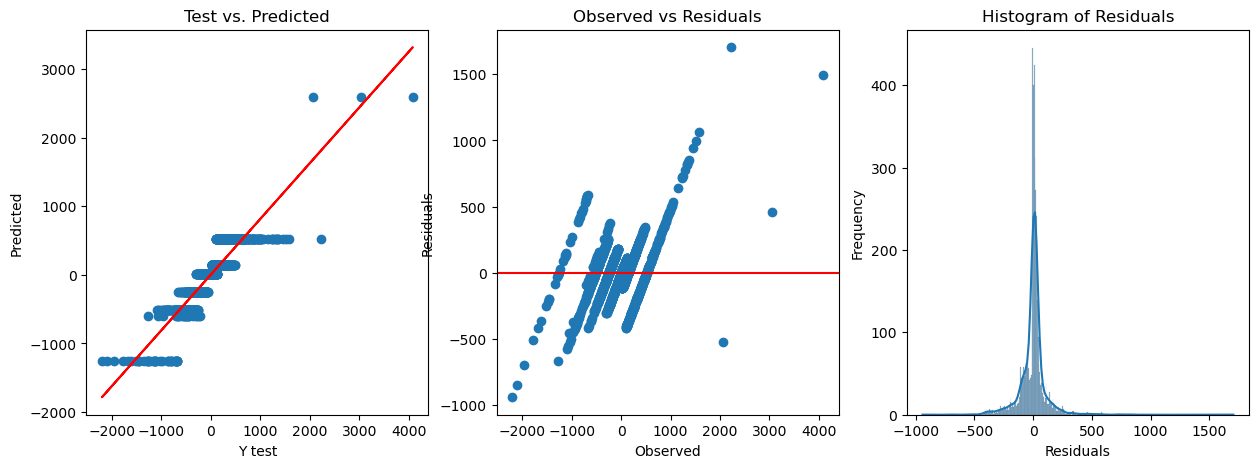

MAE:   65.3830
MSE:   14925.7433
RMSE:   122.1710
R2:   0.7967


In [27]:

tree1 = DecisionTreeRegressor(max_depth=3,
                              min_samples_leaf=2)

tree1.fit(X_train, y_train)
tree1_y_pred = tree1.predict(X_test)

print_plots_results("DecisionTree",y_test, tree1_y_pred)

#### We can see here that although the R2 score is quite high, the graphs seem problematic. for different sets of results the model is redicting the same result over and over again. This problem is even more appearent when removing the added columns (all the columns with the numeric difference of fields) as we can see in the next run of the model

DecisionTree


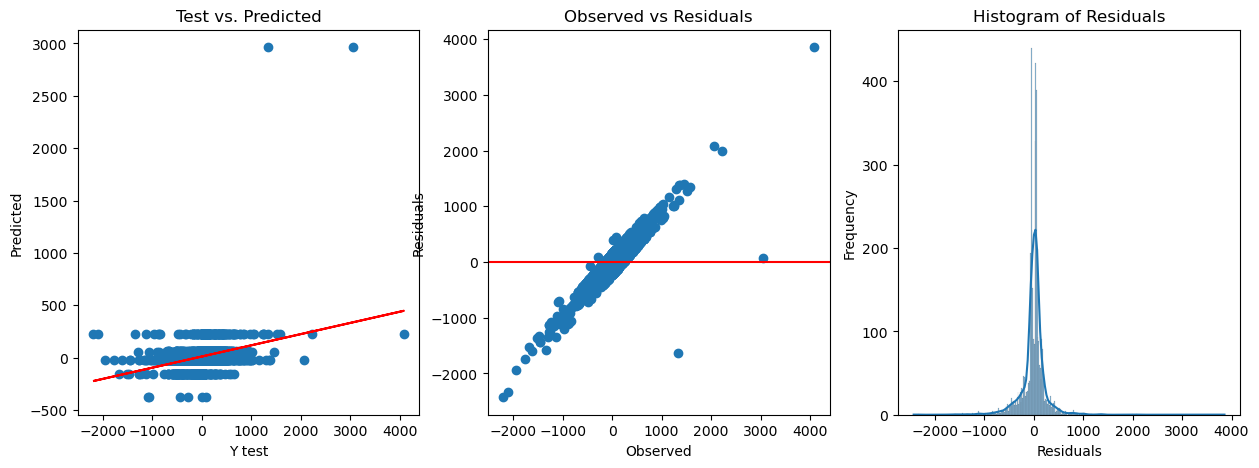

MAE:   147.4879
MSE:   67445.4969
RMSE:   259.7027
R2:   0.0816


In [28]:

tree2 = DecisionTreeRegressor(max_depth=3,
                              min_samples_leaf=2)

tree2.fit(X_train.drop(added_columns, axis=1), y_train)
tree2_y_pred = tree2.predict(X_test.drop(added_columns, axis=1))

print_plots_results("DecisionTree",y_test, tree2_y_pred)

#### The residuals graph takes on a linear appearance and the problem with predicting the same price diff for a lot of different entries is bigger. We should also notice how the R2 score this time is very low, which makes me believe the the added columns help the tree regressor greatly.

### With MinMax Normalized Data

Decision Tree with max_depth=40 and min_leaf=8


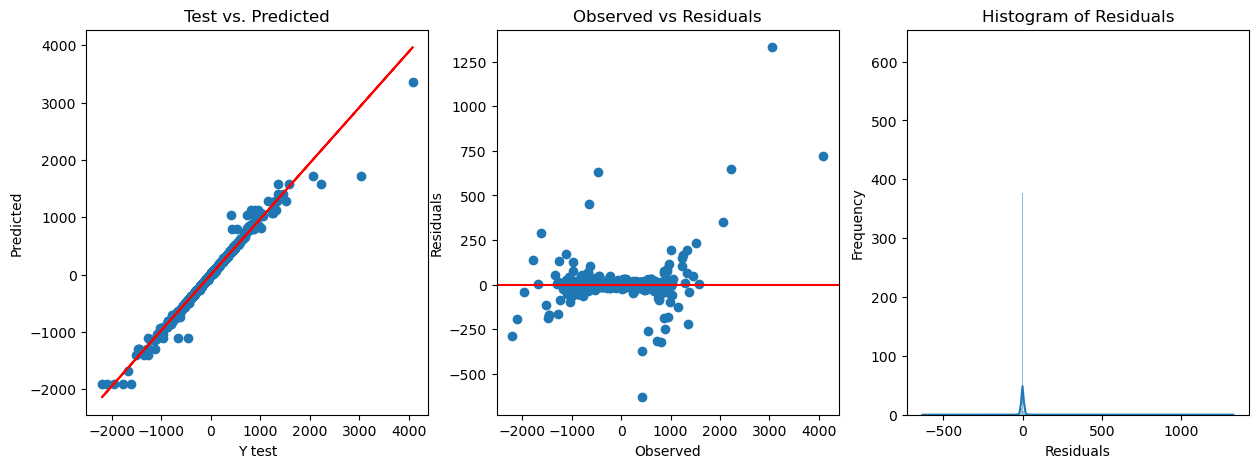

MAE:   5.5825
MSE:   1252.5493
RMSE:   35.3914
R2:   0.9829


In [29]:
tree3 = DecisionTreeRegressor(max_depth=40,
                              min_samples_leaf=8)

tree3.fit(X_train_scaled_mm, y_train)
tree3_y_pred = tree3.predict(X_test_scaled_mm)

print_plots_results('Decision Tree with max_depth=40 and min_leaf=8',y_test, tree3_y_pred)


### With Robust normalized data

Decision Tree depth 40


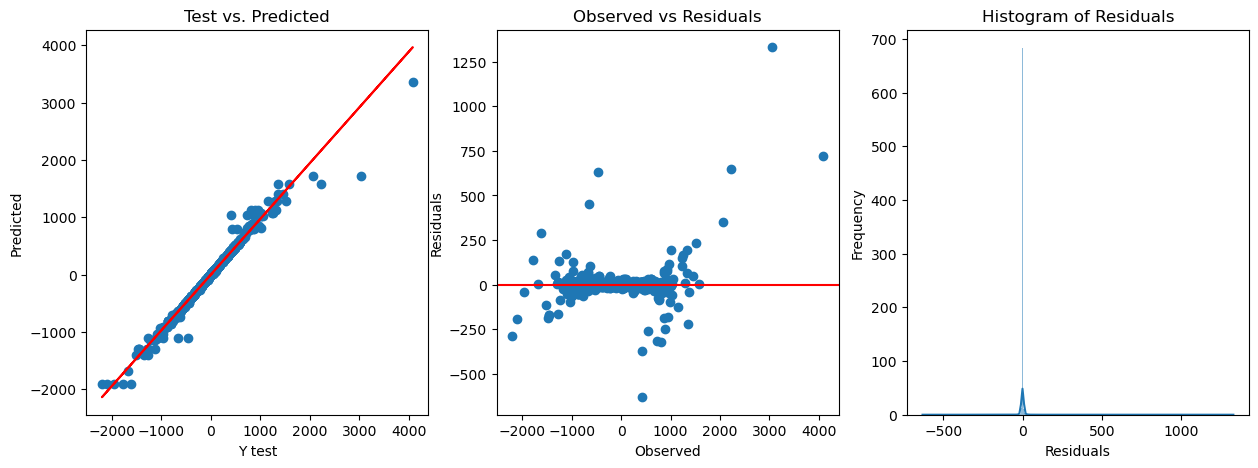

MAE:   5.5824
MSE:   1252.5520
RMSE:   35.3914
R2:   0.9829


In [30]:
tree4 = DecisionTreeRegressor(max_depth=40,
                              min_samples_leaf=8)

tree4.fit(X_train_scaled_rob, y_train)
tree4_y_pred = tree4.predict(X_test_scaled_rob)

print_plots_results('Decision Tree depth 40',y_test, tree4_y_pred)

Decision Tree with friedman mse and different depth


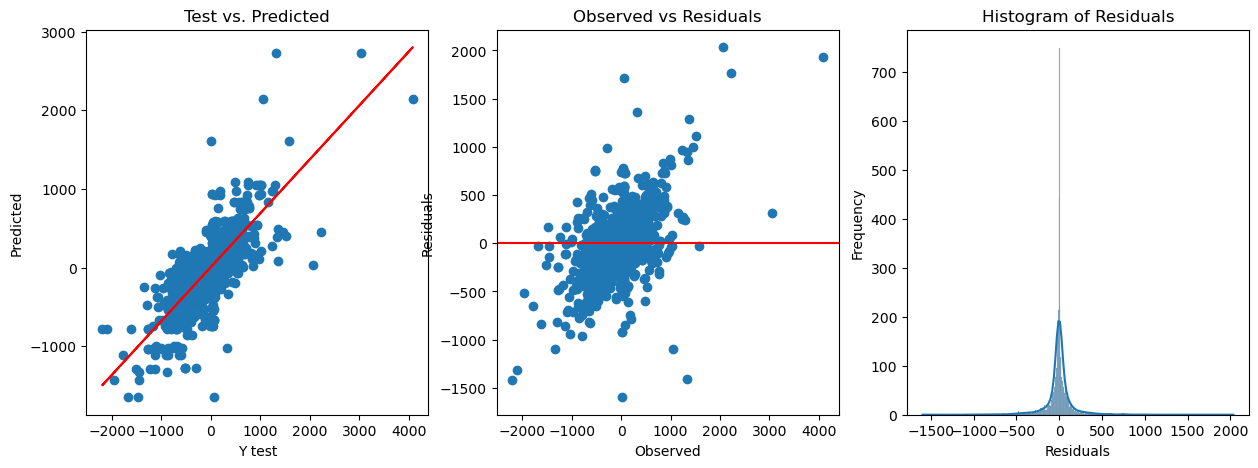

MAE:   85.1356
MSE:   30998.3559
RMSE:   176.0635
R2:   0.5779


In [31]:
tree5 = DecisionTreeRegressor(criterion='friedman_mse',
                             max_depth=35,
                              min_samples_leaf=8,
                             min_impurity_decrease=3.0)

tree5.fit(X_train.drop(added_columns, axis=1), y_train)
tree5_y_pred = tree5.predict(X_test.drop(added_columns, axis=1))

print_plots_results('Decision Tree with friedman mse and different depth',y_test, tree5_y_pred)

#### Here again as before we can see that removing the added columns lowers the R2 socre, but an important difference from before is that the points are creating less "lines" from before, but instead are "creating" a spread-out diagonal line compared to the graph models before this one.
#### Side note: running this version of algorithm with the added columns gives us more or less the same results as the last two model runs before it

Decision Tree depth 40


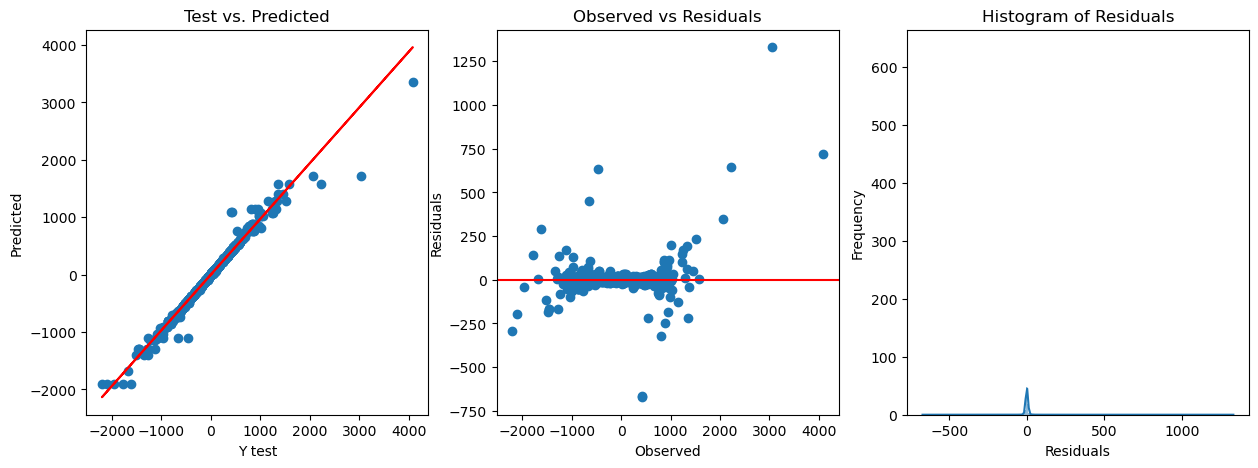

MAE:   5.5980
MSE:   1306.4188
RMSE:   36.1444
R2:   0.9822


In [32]:
tree6 = DecisionTreeRegressor(max_depth=40,
                              min_samples_leaf=8)

tree6.fit(X_ef_train, y_train)
tree6_y_pred = tree6.predict(X_ef_test)

print_plots_results('Decision Tree depth 40',y_test, tree6_y_pred)

## Conclusion
#### Although rough at first (and concerning) regarding the "lines" effect that we saw on the graphs, later runs of the model with different options increased the R2 score and the resulting graps inidcated that the error was closer to zero as we can see in the last residuals plot, the point are mostly surrounding the zero line

## Gaussian Process

/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gaussian RBF kernel


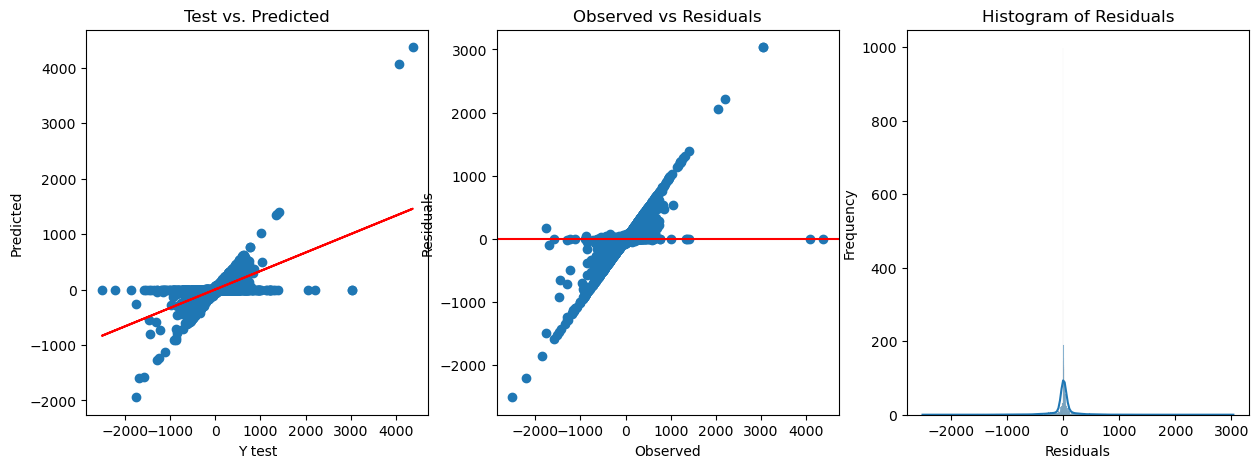

MAE:   93.5046
MSE:   51391.7414
RMSE:   226.6975
R2:   0.3710


In [33]:
rbf_kernel = C(1.0, (1e-4, 1e1)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gaussian_model1 = GaussianProcessRegressor(kernel=rbf_kernel)
gaussian_model1.fit(X_train_gp, y_train_gp)

gp1_y_pred = gaussian_model1.predict(X_test_gp)
print_plots_results('Gaussian RBF kernel',y_test_gp, gp1_y_pred)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Gaussian Matern and White kernel


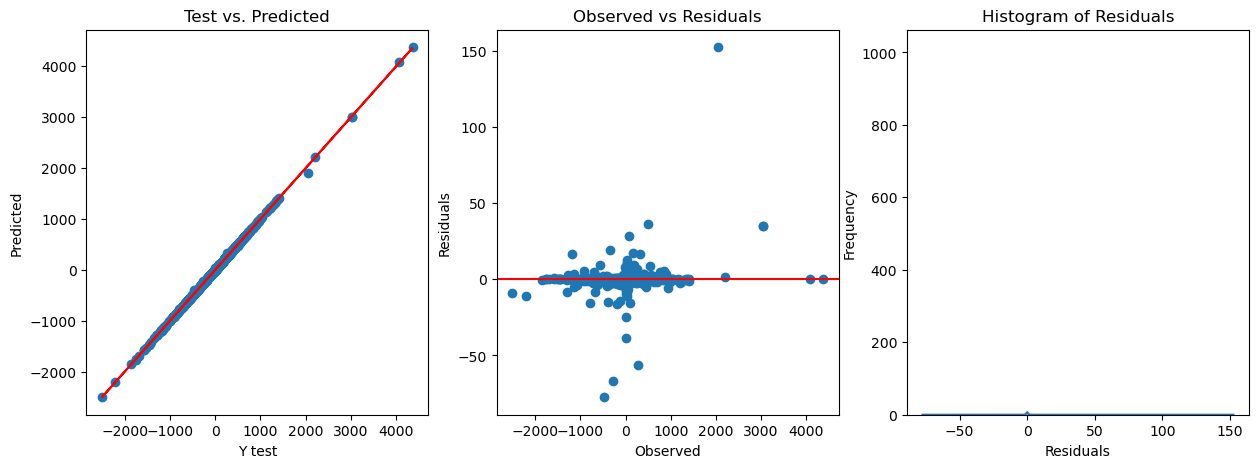

MAE:   0.3465
MSE:   11.4384
RMSE:   3.3821
R2:   0.9999


In [34]:
matern_kernel = 5**2*Matern(length_scale=40.0, length_scale_bounds=(1e-2, 1e4), nu=1.5)
white_kernel = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-6, 1e6))
kernel = matern_kernel + white_kernel

gaussian_model2 = GaussianProcessRegressor(kernel=kernel)
gaussian_model2.fit(X_train_gp.drop(added_columns,axis=1), y_train_gp)

gp2_y_pred = gaussian_model2.predict(X_test_gp.drop(added_columns,axis=1))

print_plots_results('Gaussian Matern and White kernel',y_test_gp, gp2_y_pred)

### Fitted with extra features

/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python

Gaussian Matern and White kernel revised again


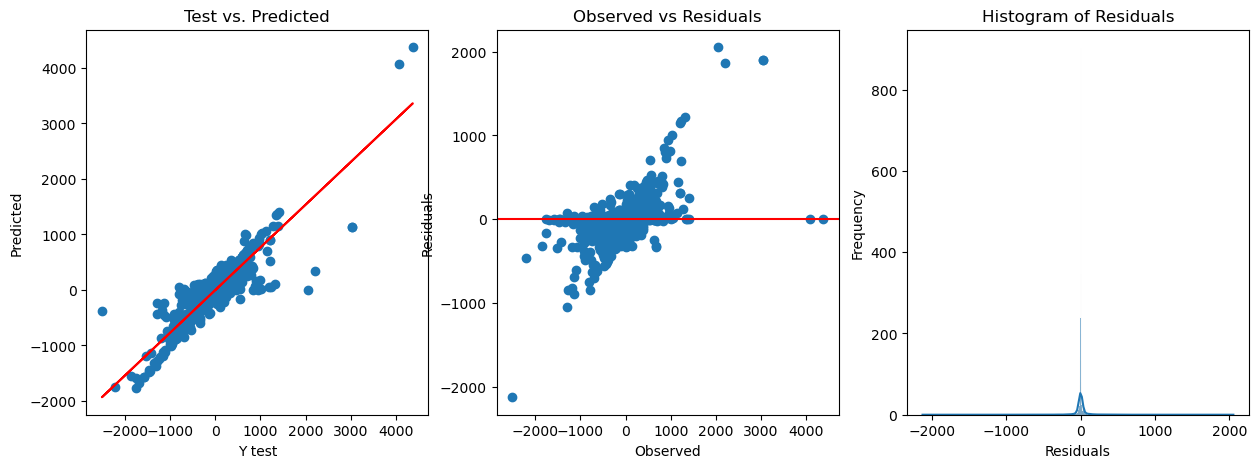

MAE:   38.2120
MSE:   14465.7188
RMSE:   120.2735
R2:   0.8229


In [35]:

matern_kernel = 5**2*Matern(length_scale=40.0, length_scale_bounds=(1e-2, 1e3), nu=1.5)
white_kernel = 5 * WhiteKernel(noise_level=0.01**2, noise_level_bounds=(1e-5, 1e6))
kernel = matern_kernel + white_kernel

gaussian_model3 = GaussianProcessRegressor(kernel=kernel)
gaussian_model3.fit(X_ef_train_gp, y_train_gp)

gp3_y_pred = gaussian_model3.predict(X_ef_test_gp)

print_plots_results('Gaussian Matern and White kernel revised again',y_test_gp, gp3_y_pred)


## Gaussian Processes Conclussion
#### By far the best R2 score out of the models we learned in class(excluding linear regression as the score is indicative of over-fitting), this may indicate that the data we have is very noisy, as gaussian models tend to handle noisy data better

## Ridge Reggression

Ridge model V1


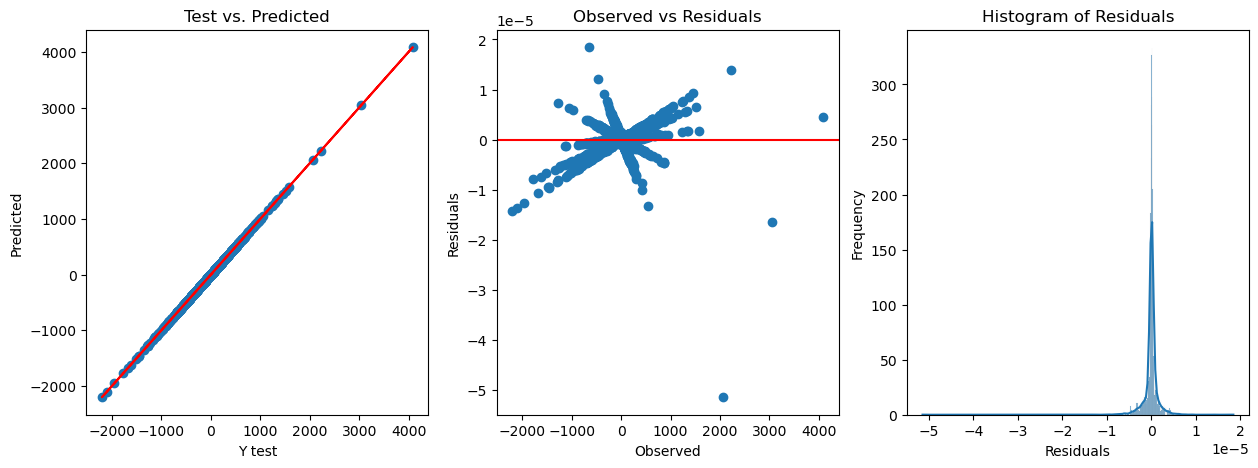

MAE:   0.0000
MSE:   0.0000
RMSE:   0.0000
R2:   1.0000


In [36]:
ridge_model1 = Ridge()
ridge_model1.fit(X_train, y_train)

ridge1_y_pred = ridge_model1.predict(X_test)

print_plots_results('Ridge model V1',y_test, ridge1_y_pred)

Ridge model V1


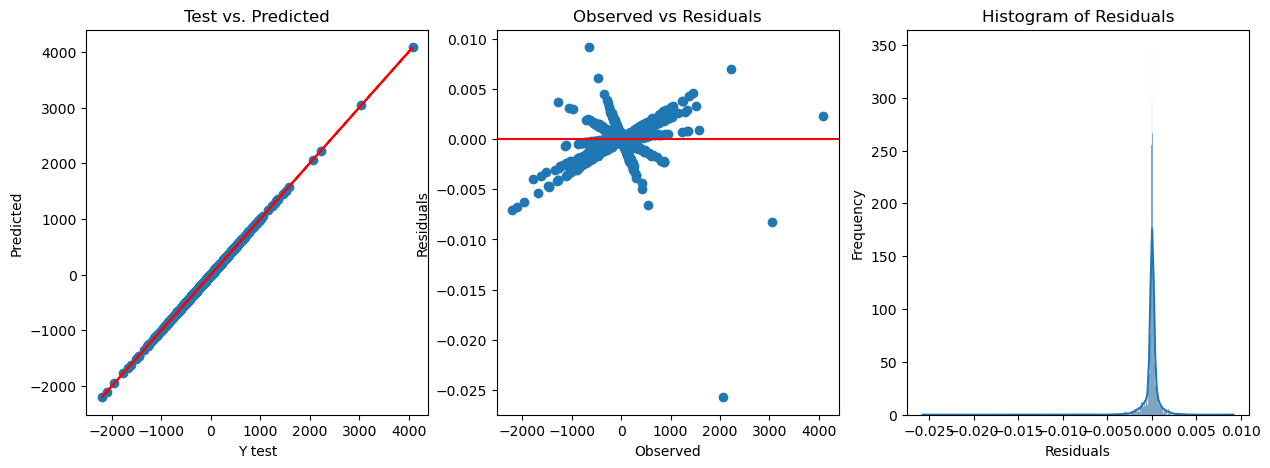

MAE:   0.0004
MSE:   0.0000
RMSE:   0.0009
R2:   1.0000


In [37]:
ridge_model2 = Ridge(alpha = 500)
ridge_model2.fit(X_train, y_train)

ridge2_y_pred= ridge_model2.predict(X_test)

print_plots_results('Ridge model V1',y_test, ridge2_y_pred)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.27003e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge model with extra feats


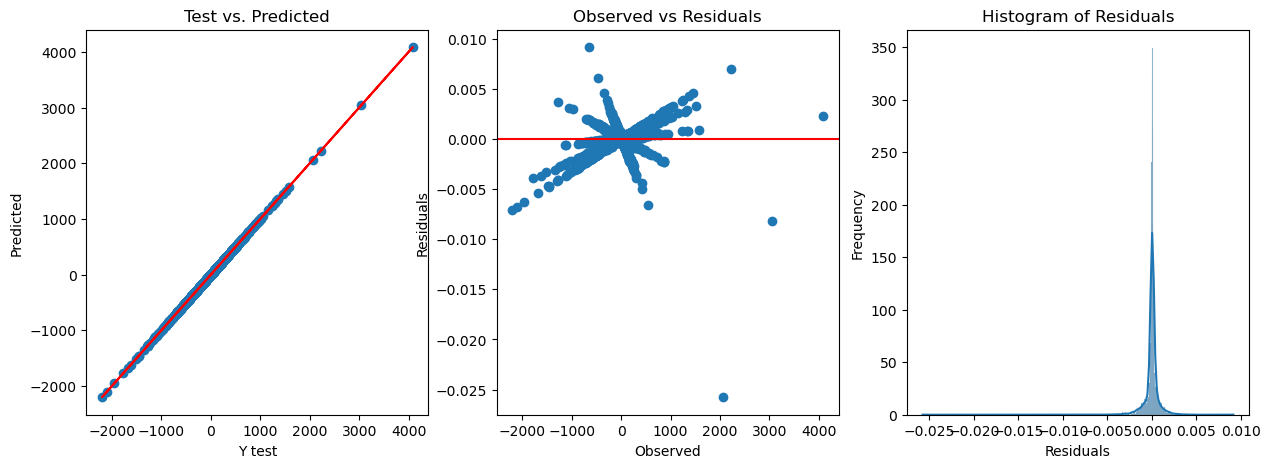

MAE:   0.0004
MSE:   0.0000
RMSE:   0.0009
R2:   1.0000


In [38]:
ridge_model3 = Ridge(alpha = 500)
ridge_model3.fit(X_ef_train, y_train)

ridge3_y_pred = ridge_model3.predict(X_ef_test)

print_plots_results('Ridge model with extra feats',y_test, ridge3_y_pred)

## Ridge Reggression Conclussion
#### It seems that this model tackless the prediction problem very poorly, this is somewhat expected as this is also a linear regression model and this data tends to be better analysed by non linear models (i.e less overfitted)

## Nearest Neighbor

KNearest


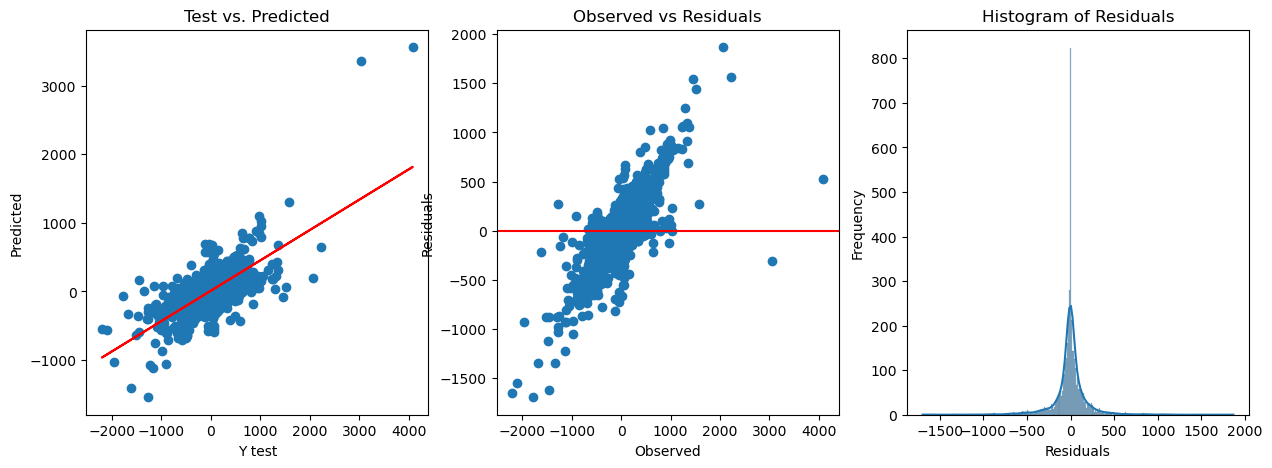

MAE:   105.7176
MSE:   39104.5026
RMSE:   197.7486
R2:   0.4675


In [39]:
neighbor_model1 = KNeighborsRegressor(n_neighbors=5, weights='uniform')
neighbor_model1.fit(X_train_scaled_mm, y_train)

kn1_y_pred = neighbor_model1.predict(X_test_scaled_mm)

print_plots_results('KNearest', y_test, kn1_y_pred)

KNearest


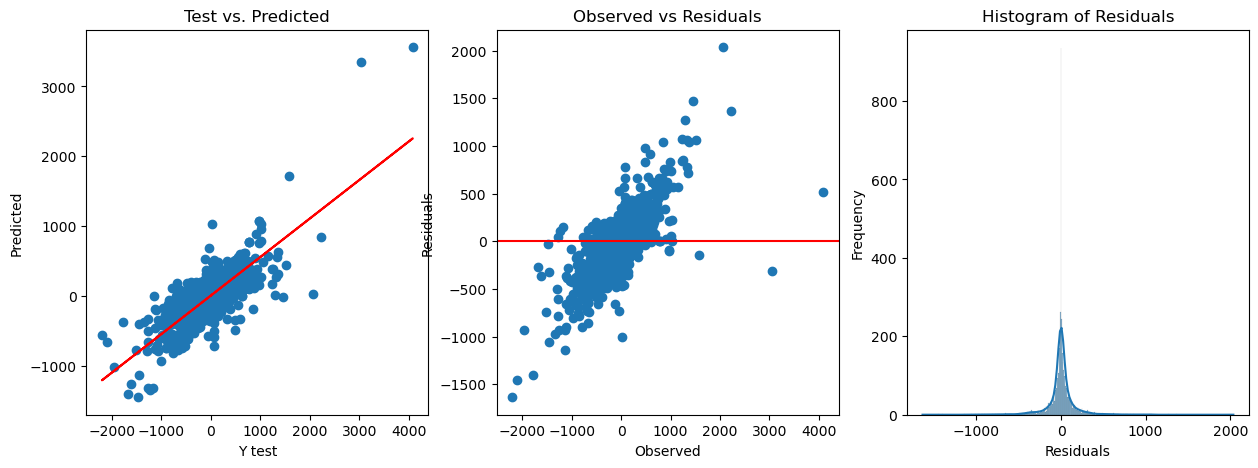

MAE:   85.3795
MSE:   28712.9990
RMSE:   169.4491
R2:   0.6090


In [40]:

neighbor_model2 = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='manhattan')
neighbor_model2.fit(X_train_scaled_mm,y_train)

kn2_y_pred = neighbor_model2.predict(X_test_scaled_mm)

print_plots_results('KNearest', y_test, kn2_y_pred)

KNearest


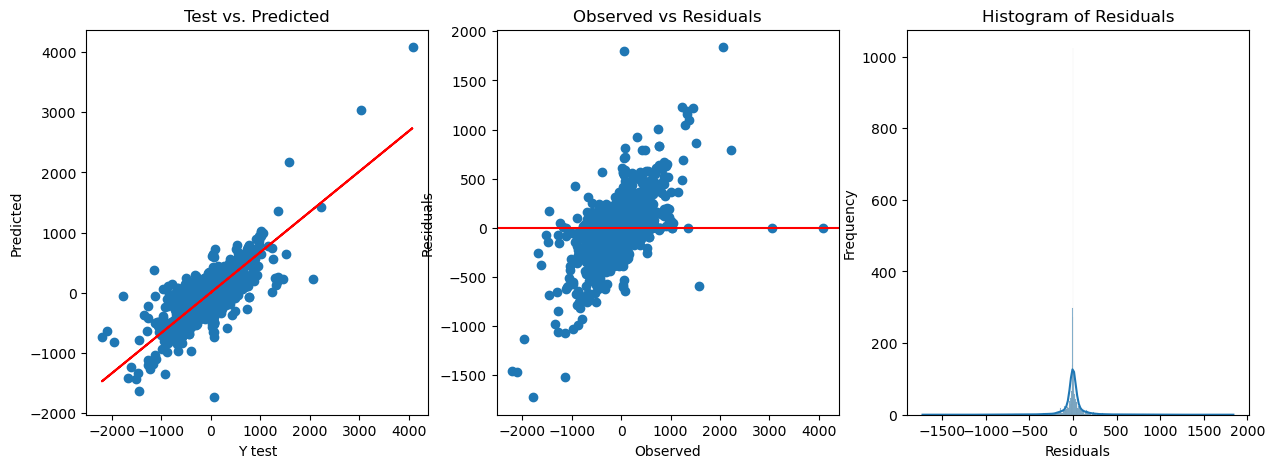

MAE:   67.8952
MSE:   24753.5817
RMSE:   157.3327
R2:   0.6629


In [41]:

neighbor_model3 = KNeighborsRegressor(n_neighbors=4, weights='distance', metric='canberra')
neighbor_model3.fit(X_train_scaled_mm,y_train)

kn3_y_pred = neighbor_model3.predict(X_test_scaled_mm)

print_plots_results('KNearest', y_test, kn3_y_pred)

## Nearest Neighbor Conclussion
#### Even after testing with different parameters with the KNearest model it seems that the model doesn't quite get a good R2 score, the "jumps" in its score are impressive though. But as we can see from the residuals graph, the errors are spread out quite loosely around the 0 line. From this we can understand that KNearest being a model that fits itself onto the distances between the different points of data, instead of fitting itself by some algorithm or trend that the points of data are going by, does not adjust well to our data.

## Neural Network

### Without Normalized Data

Neural Network


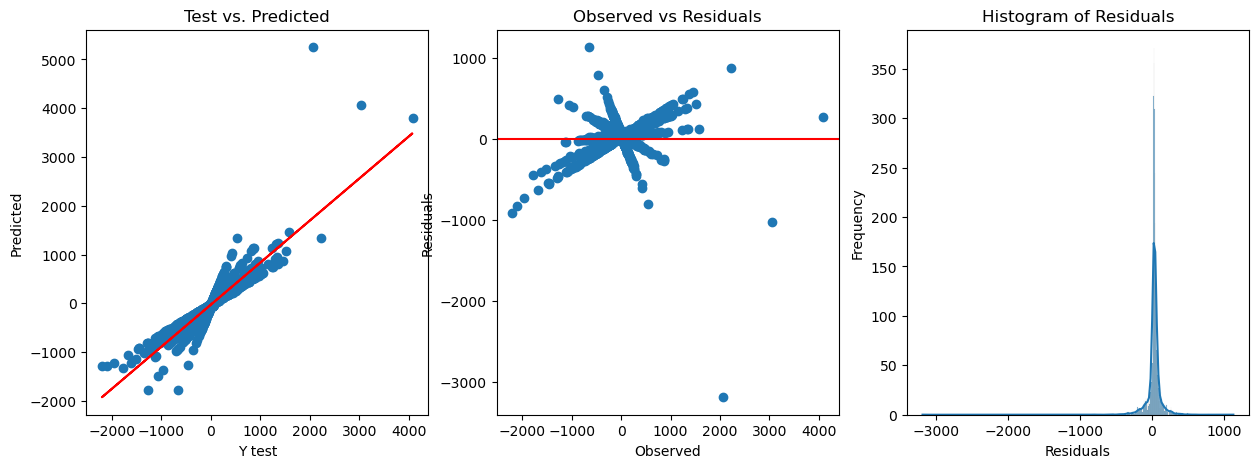

MAE:   66.2614
MSE:   12887.8971
RMSE:   113.5249
R2:   0.8245


In [42]:

mlp_model1 = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001, 
                     batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                     max_iter=1000)

mlp_model1.fit(X_train, y_train)
mlp1_y_pred = mlp_model1.predict(X_test)

print_plots_results('Neural Network', y_test, mlp1_y_pred)

### With Normalized Data

Neural Network


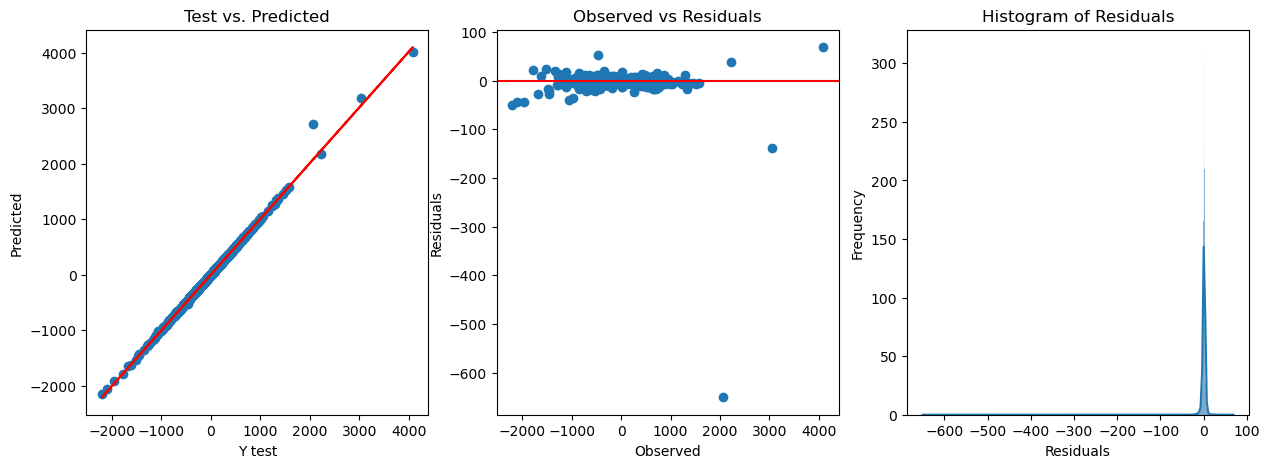

MAE:   2.2413
MSE:   117.1239
RMSE:   10.8224
R2:   0.9984


In [43]:

mlp_model2 = MLPRegressor(hidden_layer_sizes=(100, 50),
                     max_iter=1000)

mlp_model2.fit(X_train_scaled_mm, y_train)
mlp2_y_pred = mlp_model2.predict(X_test_scaled_mm)

print_plots_results('Neural Network', y_test, mlp2_y_pred)

In [44]:
best_model = MLPRegressor(hidden_layer_sizes=(100, 50),
                         max_iter=1000)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network


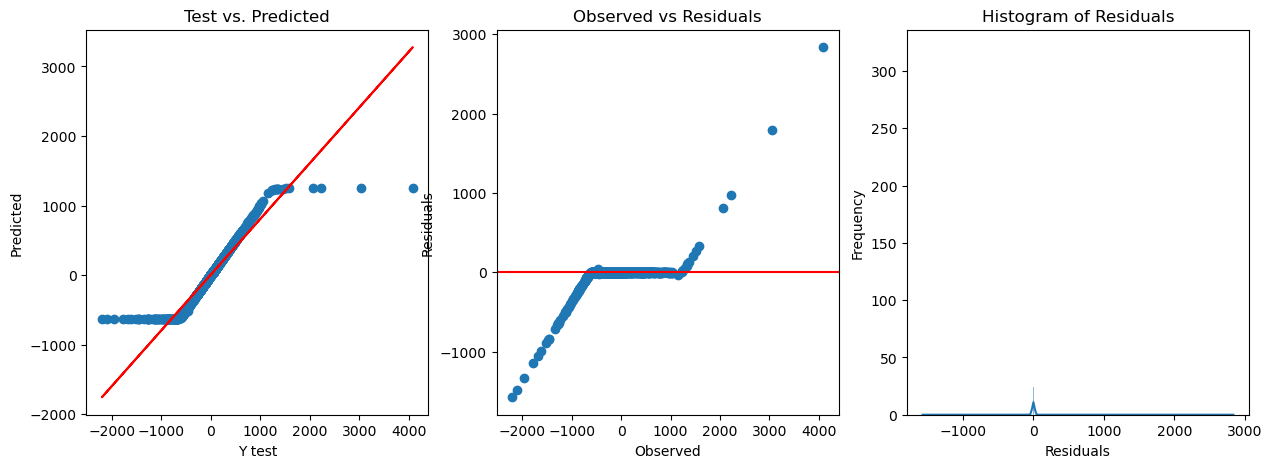

MAE:   9.8002
MSE:   7854.5726
RMSE:   88.6260
R2:   0.8930


In [65]:

mlp_model3 = MLPRegressor(hidden_layer_sizes=(100, 50), activation='logistic', solver='adam', alpha=0.0001, 
                     batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, 
                     max_iter=1000)

mlp_model3.fit(X_train_scaled_mm, y_train)
mlp3_y_pred = mlp_model3.predict(X_test_scaled_mm)

print_plots_results('Neural Network', y_test, mlp3_y_pred)

Neural Network


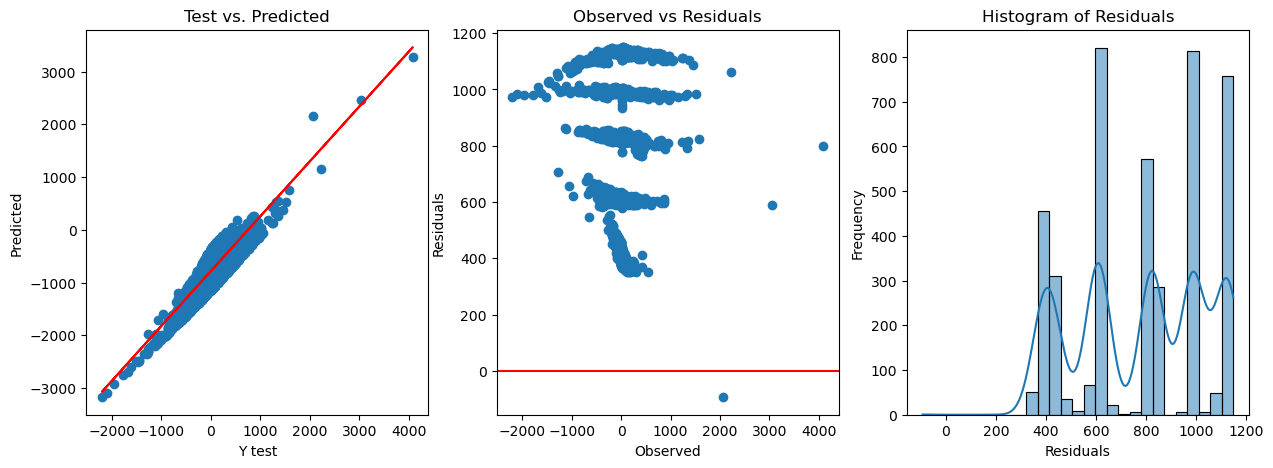

MAE:   782.7374
MSE:   678104.2995
RMSE:   823.4709
R2:   -8.2340


In [64]:

mlp_model4 = MLPRegressor(hidden_layer_sizes=(100, 50),
                          max_iter=1000)

mlp_model4.fit(X_ef_train_scaled_mm, y_train)
mlp4_y_pred = mlp_model4.predict(X_ef_test_scaled_mm)

print_plots_results('Neural Network', y_test, mlp4_y_pred)

## Neural Networks Conclussion
#### after running the MLP model we can clearly see that this is the model that best fits the data given to it.
#### The extra feautres lower its R2 grade quite a bit, even truning it negative.This point comes into contrast against running the KNeighbor model on the extra features which elevated the R2 Score. Perhaps meaning that the extra features in are highly correlated to existing features, which would not be surprising seeing that they are made up from other features. Still in this case compared to gaussian process model for example the extra features have had a great negative outcome on the model's performance

## Feature Importance

### Model-Dependent Feature Importance

In [47]:
mlp_coefficients = mlp_model4.coefs_[0]
feature_importances = np.abs(mlp_coefficients).mean(axis=1)
i = 0
print('MLP Neural Network Model-Dependent Feature By Importance:')
for feature in np.argsort(feature_importances)[::-1]:
    i += 1
    print('{0}. {1}'.format(i, all_features[feature]))

MLP Neural Network Model-Dependent Feature By Importance:
1. b_price
2. e_price
3. avg_price_diff
4. e_avg_price
5. b_avg_price
6. los
7. name
8. e_rating
9. rating_diff
10. weekend_y
11. b_rating
12. weekend_x
13. reviews_diff
14. start_date_str
15. e_reviews_rating
16. b_reviews
17. e_reviews
18. b_reviews_rating
19. ttt
20. end_of_month


In [48]:
linear_coefficients = lr3.coef_
feature_importances = np.abs(linear_coefficients)
i = 0
print('Linear Regression Model-Dependent Feature By Importance:')
for feature in np.argsort(feature_importances)[::-1]:
    i += 1
    print('{0}. {1}'.format(i, all_features[feature]))

Linear Regression Model-Dependent Feature By Importance:
1. e_price
2. b_price
3. los
4. ttt
5. weekend_y
6. weekend_x
7. e_rating
8. rating_diff
9. b_rating
10. avg_price_diff
11. name
12. e_avg_price
13. e_reviews
14. b_reviews
15. b_avg_price
16. reviews_diff
17. start_date_str
18. e_reviews_rating
19. b_reviews_rating
20. end_of_month


### Model-Agnostic Feature Importance

In [49]:
def get_permutation_importance(model, test_set, target_test_set, features, model_name):
    feature_importances = permutation_importance(model, test_set, target_test_set, n_repeats=20)
    i = 0
    print('{0} Features By Importance'.format(model_name))
    for feature in feature_importances.importances_mean.argsort()[::-1]:
        i+=1
        print('{0}. {1}'.format(i, features[feature]))

In [50]:
get_permutation_importance(mlp_model4,
                           X_ef_test_scaled_mm,
                           y_test,
                           X_ef_test.columns,
                           'Neural Network')

Neural Network Features By Importance
1. b_price
2. e_price
3. e_avg_price
4. b_avg_price
5. los
6. avg_price_diff
7. b_reviews
8. weekend_x
9. reviews_diff
10. e_rating
11. name
12. start_date_str
13. end_of_month
14. rating_diff
15. b_reviews_rating
16. ttt
17. e_reviews
18. e_reviews_rating
19. b_rating
20. weekend_y


In [51]:
get_permutation_importance(neighbor_model3,
                           X_test_scaled_mm,
                           y_test,
                           X_ef_train.columns,
                           'KNeighbor Model')

KNeighbor Model Features By Importance
1. start_date_str
2. name
3. avg_price_diff
4. b_reviews
5. e_reviews
6. b_avg_price
7. los
8. e_avg_price
9. b_rating
10. rating_diff
11. ttt
12. e_price
13. e_rating
14. reviews_diff
15. b_price
16. weekend_y
17. weekend_x


## R2 Scores Distribution over hotels

In [52]:
def get_hotel_name(hotels_db,hotel_code):
    hotels_db[hotels_db['hotel_code']==hotel_code]['hotel_name'].values[0]

In [53]:
def plot_hotel_r2_distribution(model, hotels_db, data, scaler, scaled=False):
    r2_scores = pd.DataFrame([[0]*2]*len(hotels_db.index))
    r2_scores.columns = ['hotel_name','r2_score']
    r2_scores['hotel_name'] = hotels_db['hotel_name']
    for hotel in hotels_db['hotel_code'].tolist():
        X_hotel = data[data['name']==hotel].drop('price_diff', axis=1)
        y_hotel = data[data['name']==hotel]['price_diff']
        X_hotel_scaled = scaler.transform(X_hotel)
        predicted_y_hotel = model.predict(X_hotel_scaled)
        r2_scores[r2_scores['hotel_name']==get_hotel_name(hotels_db, hotel)] = r2_score(y_hotel,predicted_y_hotel)
    print(r2_scores)
    plt.figure(figsize=(8,5))
    sns.displot(r2_scores, x='r2_score', bins=10, stat='count',kde=True, color='green')
    plt.title('Distribution of Hotel R2 Scores')
    plt.xlabel('R2 Score')
    plt.ylabel('Density')
    plt.show()

In [54]:
model_to_use = best_model
model_to_use.fit(X_train_scaled_mm, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings

                                         hotel_name  r2_score
0                                            Pod 51         0
1            Hyatt Place New York City/Times Square         0
2            AC Hotel by Marriott New York Downtown         0
3    Delta Hotels by Marriott New York Times Square         0
4                              Broadway Plaza Hotel         0
..                                              ...       ...
214              Merrion Row Hotel and Public House         0
215                          The St. Regis New York         0
216                                   Smyth Tribeca         0
217                                 Dylan Hotel NYC         0
218                          The Peninsula New York         0

[219 rows x 2 columns]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 800x500 with 0 Axes>

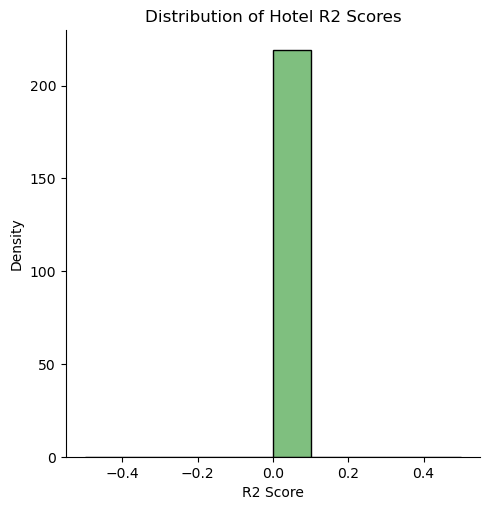

In [55]:
plot_hotel_r2_distribution(model_to_use, hotel_names_index, hotels, MinMaxScaler().fit(X_train))

## Testing the best model

### Splitting Data

In [56]:
best_train = hotels[hotels['ttt']<=25]
best_test = hotels[hotels['ttt']>25]

In [57]:
X_best_train = best_train.drop('price_diff',axis=1)
X_best_test = best_test.drop('price_diff',axis=1)
y_best_train = best_train['price_diff']
y_best_test = best_test['price_diff']

In [58]:
minmax_scaler = MinMaxScaler()
X_best_train_scaled = minmax_scaler.fit_transform(X_best_train)
X_best_test_scaled = minmax_scaler.transform(X_best_test)

Best Model - Neural Network


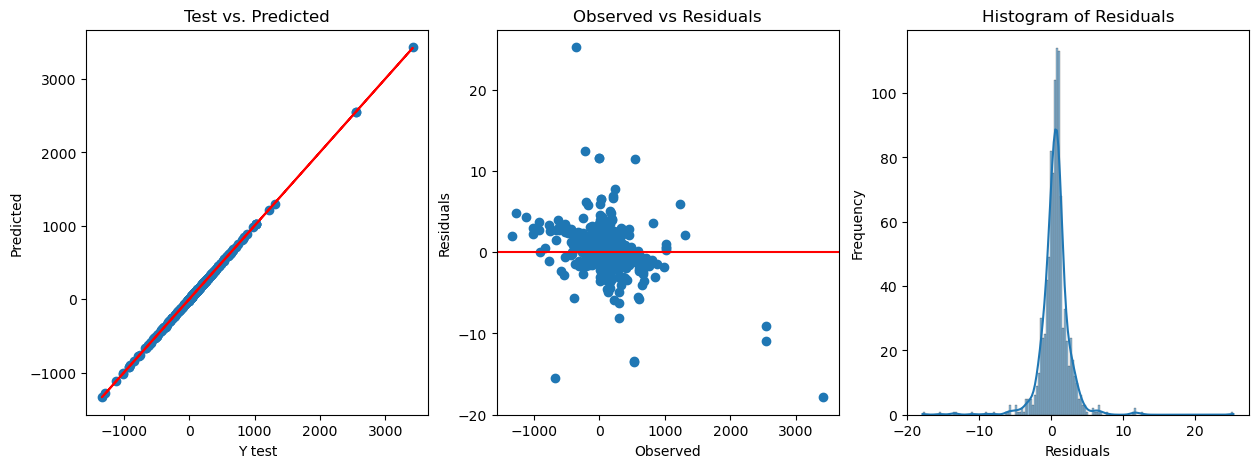

MAE:   1.3798
MSE:   5.2235
RMSE:   2.2855
R2:   0.9999


In [59]:
best_model.fit(X_best_train_scaled, y_best_train)
best_predict = best_model.predict(X_best_test_scaled)

print_plots_results('Best Model - Neural Network',y_best_test, best_predict)